In [ ]:
import gdown
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pprint
import random
import pandas as pd
import pulp
import itertools
import requests
import random
from geopy.distance import geodesic
import time
import pandas as pd
import os

Downloading...
From (original): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf
From (redirected): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf&confirm=t&uuid=0018c108-4923-43e1-a5a8-7aad09255ce7
To: /content/mpsis_setup.py
100%|██████████| 12.1k/12.1k [00:00<00:00, 24.5MB/s]


Mounted at /content/drive


In [ ]:
def generate_random_point(sw_lat, sw_lng, ne_lat, ne_lng):
    lat = random.uniform(sw_lat, ne_lat)
    lng = random.uniform(sw_lng, ne_lng)
    return lat, lng

def snap_to_road(lat, lng, api_key):
    url = f'https://roads.googleapis.com/v1/nearestRoads?points={lat},{lng}&key={api_key}'
    response = requests.get(url)
    data = response.json()
    if 'snappedPoints' in data and len(data['snappedPoints']) > 0:
        snapped_point = data['snappedPoints'][0]['location']
        return snapped_point['latitude'], snapped_point['longitude']
    return None

def get_road_distance_time(origin, destination, api_key):
    origin_str = f'{origin[0]}, {origin[1]}'
    destination_str = f'{destination[0]}, {destination[1]}'
    departure_time = int(time.time()) + 24 * 3600
    url = (
        f'https://maps.googleapis.com/maps/api/distancematrix/json?units=metric&origins={origin_str}'
        f'&destinations={destination_str}&mode=driving&departure_time={departure_time}&key={API_KEY}'
    )
    response = requests.get(url)
    data = response.json()

    if data['status'] == 'OK':
        element = data['rows'][0]['elements'][0]
        if element['status'] == 'OK':
            distance = element['distance']['text']
            duration = element['duration']['text']
            return distance, duration
        else:
            return None, None
    else:
        return None, None

def find_center(sw_lat, sw_lng, ne_lat, ne_lng):
    center_lat = (sw_lat + ne_lat) / 2
    center_lng = (sw_lng + ne_lng) / 2
    return center_lat, center_lng

def generate_list(n, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")
    result = [0]
    random_values = np.random.rand(n - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    result.extend(rounded_values)

    return result

In [ ]:
df = pd.read_csv(os.path.join("", "FILE"))

In [ ]:
def generate_new_points(n, sw_lat, sw_lng, ne_lat, ne_lng):
    road_starting_points = []
    original_starting_points = []
    attempts = 0

    while len(road_starting_points) < n:
        attempts += 1
        point = generate_random_point(sw_lat, sw_lng, ne_lat, ne_lng)
        road_point = snap_to_road(point[0], point[1], API_KEY)

        if road_point:
            road_starting_points.append(road_point)
            original_starting_points.append(point)
            print(f"Point {len(road_starting_points)}: Original = {point[0]}, {point[1]}; Snapped = {road_point[0]}, {road_point[1]}")
        else:
            print(f"Attempt {attempts}: No road found nearby for Latitude = {point[0]}, Longitude = {point[1]}")

    return road_starting_points, original_starting_points

nof_probes = 50
road_starting_points, original_starting_points = generate_new_points(nof_probes, sw_lat, sw_lng, ne_lat, ne_lng)

Attempt 1: No road found nearby for Latitude = 49.20195400112858, Longitude = 23.0577650809616
Point 1: Original = 51.88915783157516, 11.775885024230515; Snapped = 51.889392217791055, 11.776765176700751
Attempt 3: No road found nearby for Latitude = 53.088850562223946, Longitude = 15.799063933416214
Attempt 4: No road found nearby for Latitude = 49.45253504734533, Longitude = 21.175202151693348
Attempt 5: No road found nearby for Latitude = 49.82482840654777, Longitude = 14.218264922732434
Point 2: Original = 52.27599549157826, 22.998038166745626; Snapped = 52.27604346422597, 22.998186088678796
Attempt 7: No road found nearby for Latitude = 46.98942456504708, Longitude = 22.336703468011777
Attempt 8: No road found nearby for Latitude = 48.662638778615786, Longitude = 18.355172653594693
Attempt 9: No road found nearby for Latitude = 52.57240420964951, Longitude = 21.007720382983926
Attempt 10: No road found nearby for Latitude = 52.00921873675819, Longitude = 16.14953908760075
Attempt 1

In [ ]:
import copy

def update_row_and_column(df, road_points, original_points, new_point_index):
    new_df = df.copy()

    new_df.at[0, 'Original Latitude'] = original_points[new_point_index][0]
    new_df.at[0, 'Original Longitude'] = original_points[new_point_index][1]
    new_df.at[0, 'Snapped Latitude'] = road_points[new_point_index][0]
    new_df.at[0, 'Snapped Longitude'] = road_points[new_point_index][1]

    for j in range(21):
        if j == 0:
            new_df.at[0, f'Real Distance to Point {j + 1}'] = '0'
            new_df.at[0, f'Time to Point {j + 1}'] = '0'
            new_df.at[0, f'Road Distance to Point {j + 1}'] = '0'

            new_df.at[j, f'Real Distance to Point {0 + 1}'] = '0'
            new_df.at[j, f'Time to Point {0 + 1}'] = '0'
            new_df.at[j, f'Road Distance to Point {0 + 1}'] = '0'
        else:
            straight_distance = geodesic(road_points[new_point_index], road_points[j]).kilometers

            road_distance, travel_time = get_road_distance_time(road_points[new_point_index], road_points[j], API_KEY)

            new_df.at[0, f'Real Distance to Point {j + 1}'] = f'{straight_distance:.2f}'
            new_df.at[0, f'Time to Point {j + 1}'] = travel_time if travel_time else 'N/A'
            new_df.at[0, f'Road Distance to Point {j + 1}'] = road_distance if road_distance else 'N/A'

            new_df.at[j, f'Real Distance to Point {0 + 1}'] = f'{straight_distance:.2f}'
            new_df.at[j, f'Time to Point {0 + 1}'] = travel_time if travel_time else 'N/A'
            new_df.at[j, f'Road Distance to Point {0 + 1}'] = road_distance if road_distance else 'N/A'

    return new_df

In [ ]:
for i in range(nof_probes):
    print(f"run {i}")
    new_df = update_row_and_column(df, road_starting_points, original_starting_points, i)
    input_data.append(new_df)

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19
run 20
run 21
run 22
run 23
run 24
run 25
run 26
run 27
run 28
run 29
run 30
run 31
run 32
run 33
run 34
run 35
run 36
run 37
run 38
run 39
run 40
run 41
run 42
run 43
run 44
run 45
run 46
run 47
run 48
run 49


VRPSDP

In [ ]:
cost_function = []
print(len(input_data))

number_of_clients = 20
m = 2
Q = 100

d = generate_list(number_of_clients + 1, 0.5 * Q * m)
p = generate_list(number_of_clients + 1, 0.5 * Q * m)

21


In [ ]:
cost_function = []

for input_df in input_data:
  real_distance_columns = [col for col in input_df.columns if col.startswith('Road Distance to Point')]
  df_filtered = input_df[real_distance_columns]

  num_points = len(df_filtered)
  cost = [[0] * num_points for _ in range(num_points)]

  for i in range(num_points):
      for j in range(num_points):
          if i != j:
              column_name = f'Road Distance to Point {j + 1}'
              distance = df_filtered.iloc[i][column_name].replace(",", "").replace(" km", "").replace(" m", "")
              cost[i][j] = int(float(distance)*100)

  vrpsdp = pulp.LpProblem("VRPSDP", pulp.LpMinimize)

  x = pulp.LpVariable.dicts("x", [(i, j, k) for i in range(number_of_clients+1) for j in range(number_of_clients+1) for k in range(m)], cat='Binary')
  y = pulp.LpVariable.dicts("y", [(i, j) for i in range(number_of_clients+1) for j in range(number_of_clients+1)], lowBound=0, cat='Continuous')
  z = pulp.LpVariable.dicts("z", [(i, j) for i in range(number_of_clients+1) for j in range(number_of_clients+1)], lowBound=0, cat='Continuous')

  vrpsdp += pulp.lpSum(cost[i][j] * x[i, j, k] for k in range(m) for i in range(number_of_clients+1) for j in range(number_of_clients+1) if i != j)

  for j in range(1, number_of_clients+1):
      vrpsdp += pulp.lpSum(x[i, j, k] for k in range(m) for i in range(number_of_clients+1) if i != j) == 1

  for k in range(m):
    for j in range(number_of_clients+1):
      vrpsdp += pulp.lpSum(x[i,j,k] for i in range(number_of_clients+1)) - pulp.lpSum(x[j,i,k] for i in range(number_of_clients+1)) == 0

  for k in range(m):
    vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, number_of_clients+1)) == 1

  for j in range(1, number_of_clients+1):
    vrpsdp += pulp.lpSum(y[j,i] for i in range(number_of_clients+1)) - pulp.lpSum(y[i,j] for i in range(number_of_clients+1)) == p[j]

  for j in range(1, number_of_clients+1):
    vrpsdp += pulp.lpSum(z[i,j] for i in range(number_of_clients+1)) - pulp.lpSum(z[j,i] for i in range(number_of_clients+1)) == d[j]

  for i in range(number_of_clients+1):
    for j in range(number_of_clients+1):
      if i != j:
        vrpsdp += y[i,j] + z[i,j] <= Q * pulp.lpSum(x[i,j,k] for k in range(m))

  vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, number_of_clients+1) for k in range(m)) == m
  for i in range(1,number_of_clients+1):
    vrpsdp += pulp.lpSum(x[i,j,k] for j in range(number_of_clients+1) for k in range(m) if i != j) == 1

  vrpsdp.solve()

  if pulp.LpStatus[vrpsdp.status] == "Optimal":
    print(f"Total Cost: {pulp.value(vrpsdp.objective)/100}")
    cost_function_road_distance.append(pulp.value(vrpsdp.objective)/100)

Total Cost: 5803.999997269154
Total Cost: 6618.000000000027
Total Cost: 4298.000000000031
Total Cost: 4310.0
Total Cost: 5154.000000000088
Total Cost: 4358.0
Total Cost: 4845.999994737232
Total Cost: 4247.99999999994
Total Cost: 5153.999612433024
Total Cost: 5390.000000001645
Total Cost: 5759.0
Total Cost: 4500.000000001114
Total Cost: 5327.999999999981
Total Cost: 5945.999994004728


In [ ]:
road_starting_points = [road_points[0]] + road_starting_points
original_starting_points = [original_points[0]] + original_starting_points

distance_list = []
center_latitude, center_longitude = find_center(sw_lat, sw_lng, ne_lat, ne_lng)

for point in road_starting_points:
    distance_list.append(geodesic((center_latitude, center_longitude), point).kilometers)
# cost_function = [
#     4520.0, 4830.0, 3902.0, 3914.0, 3748.99999949496, 3909.999999999999,
#     3683.0, 3609.0, 4228.0, 4220.0, 4369.000000000022, 3931.0, 4104.0,
#     3969.9999946824923, 3990.0, 4307.0, 3877.9999999999986, 3595.0000000000073,
#     4325.0, 4113.0, 3792.0
# ]

print(len(distance_list))
print(len(cost_function))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(cost_function, distance_list, color='blue', marker='o')

plt.xlabel('Cost Function')
plt.ylabel('Distance [km]')

plt.grid(True)

plt.show()

In [ ]:
import numpy as np
mean = np.mean(cost_function)
std_dev = np.std(cost_function)

max_value = np.max(cost_function)

min_value = np.min(cost_function)

print(f"Standard Deviation: {std_dev}")
print(f"Maximum Value: {max_value}")
print(f"Minimum Value: {min_value}")
print(f"Mean Value: {mean}")

CVRP

In [ ]:
print(len(input_data))

number_of_clients = 20
number_of_vehicles = 2
capacity_of_vehicle = 100
demand_of_client = generate_list(number_of_clients + 1, 0.5 * capacity_of_vehicle * number_of_vehicles)


In [ ]:
cost_function = []

for input_df in input_data:
  real_distance_columns = [col for col in input_df.columns if col.startswith('Road Distance to Point')]
  df_filtered = input_df[real_distance_columns]

  num_points = len(df_filtered)
  cost = [[0] * num_points for _ in range(num_points)]

  for i in range(num_points):
      for j in range(num_points):
          if i != j:
              column_name = f'Road Distance to Point {j + 1}'
              if df_filtered.iloc[i][column_name] == 'N/A':
                distance = 1000000
              else:
                distance = df_filtered.iloc[i][column_name].replace(",", "").replace(" km", "").replace(" m", "")
              cost[i][j] = int(float(distance))

    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
          for k in range(number_of_vehicles)]
          for j in range(number_of_clients + 1)]
        for i in range(number_of_clients + 1)]
    u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")

    problem += pulp.lpSum(cost_shiffted[i][j] * x[i][j][k] if i != j else 0
                          for k in range(number_of_vehicles)
                          for j in range(number_of_clients + 1)
                          for i in range(number_of_clients + 1))

    for j in range(1, number_of_clients + 1):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0
                              for i in range(number_of_clients + 1)
                              for k in range(number_of_vehicles)) == 1

    for k in range(number_of_vehicles):
        problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

    for k in range(number_of_vehicles):
        for j in range(number_of_clients + 1):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)) - \
                      pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

    for k in range(number_of_vehicles):
        problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                              for i in range(number_of_clients + 1)
                              for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle

    for i in range(1, number_of_clients + 1):
        for j in range(1, number_of_clients + 1):
            if i != j:
                for k in range(number_of_vehicles):
                    problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1
  prob.solve()

  if pulp.LpStatus[prob.status] == "Optimal":
    print("Total Cost:", pulp.value(prob.objective))
  cost_function.append(pulp.value(prob.objective))

In [ ]:
distance_list = []
center_latitude, center_longitude = find_center(sw_lat, sw_lng, ne_lat, ne_lng)

for point in road_starting_points:
    distance_list.append(geodesic((center_latitude, center_longitude), point).kilometers)
print(len(distance_list))
print(len(cost_function))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(cost_function, distance_list, color='blue', marker='o')

plt.xlabel('Cost Function')
plt.ylabel('Distance [km]')
plt.grid(True)

plt.show()

In [ ]:
import numpy as np

mean = np.mean(cost_function)
std_dev = np.std(cost_function)
max_value = np.max(cost_function)
min_value = np.min(cost_function)

print(f"Standard Deviation: {std_dev}")
print(f"Maximum Value: {max_value}")
print(f"Minimum Value: {min_value}")
print(f"Mean Value: {mean}")

VRPB

In [ ]:
number_of_clients = 15

L_B = list(range(1, number_of_clients + 1))
SOURCE = 0
midpoint = number_of_clients - 4
L = L_B[:midpoint]
L0 = L[:]
L0.insert(0,0)
B = L_B[midpoint:]
B0 = B[:]
B0.insert(0,0)
Cu = L_B
V = list(range(0, number_of_clients + 1))
Q = 100
K = 4

D = generate_list(len(L) + 1, 0.5 * Q * K)
D.append(1)
D.append(1)
D.append(1)
D.append(1)

Kl = K
Kb = K

[16, 17, 18, 19, 20]
105.0


In [ ]:
from posixpath import join
cost_function_road_distance = []
for input_df in input_data:
  real_distance_columns = [col for col in input_df.columns if col.startswith('Road Distance to Point')]
  df_filtered = input_df[real_distance_columns]

  num_points = len(df_filtered)
  cost = [[0] * num_points for _ in range(num_points)]

  for i in range(num_points):
      for j in range(num_points):
          if i != j:
              column_name = f'Road Distance to Point {j + 1}'
              if df_filtered.iloc[i][column_name] == 'N/A':
                distance = 1000000
              else:
                distance = df_filtered.iloc[i][column_name].replace(",", "").replace(" km", "").replace(" m", "")
              cost[i][j] = int(float(distance))

  s = pulp.LpVariable.dicts('s', [(i, j) for i in V for j in V if i != j], cat = pulp.LpBinary)
  e = pulp.LpVariable.dicts('e', [(i, j) for i in L for j in B0 if i != j], cat = pulp.LpBinary)
  l = pulp.LpVariable.dicts('l', [(i, j) for i in V for j in V if i != j], 0, cat = "Continuous")

  model = pulp.LpProblem("vehicle_routing", pulp.LpMinimize)

  cost_function_model = pulp.lpSum(s[i,j] * cost[i][j] for i in V for j in V if i != j) + pulp.lpSum(e[i,j] * cost[i][j] for i in L for j in B0 if i != j)
  model += cost_function_model

  model += pulp.lpSum(s[i,j] for i in L0 for j in L if i != j) == len(L)

  for j in L:
    model += pulp.lpSum(l[i,j] for i in L0 if i != j) - pulp.lpSum(l[j,k] for k in L0 if k != j) == D[j]

  for j in L:
    model += pulp.lpSum(s[i,j] for i in L0 if i != j) == 1

  for j in L:
    model += pulp.lpSum(s[j,k] for k in L if k != j) + pulp.lpSum(e[j,k] for k in B0 if k != j)  ==  pulp.lpSum(s[(i,j)] for i in L0 if i != j)

  for j in L:
    for i in L0:
      if i != j:
        model += l[(i,j)] <= Q * s[(i,j)]

  fraaction7 = pulp.lpSum(D[j] for j in L)/Q
  model += pulp.lpSum(s[0,j] for j in L) >= max(float(fraaction7.value()),Kl)

  model += pulp.lpSum(s[i,j] for i in B for j in B0 if i != j) == len(B)

  for j in B:
    model += pulp.lpSum(l[i,j] for i in B if i != j) - pulp.lpSum(l[(j,k)] for k in B0 if k != j) == -D[j]

  for j in B:
    model += pulp.lpSum(s[j,i] for i in B0 if j != i) == 1

  for j in B:
    model += pulp.lpSum(s[k,j] for k in B if k != j) + pulp.lpSum(e[k,j] for k in L) == pulp.lpSum(s[(j,i)] for i in B0 if j != i)

  for j in B0:
    for i in B:
      if i != j:
        model += l[i,j] <= Q * s[i,j]

  fraaction13 = pulp.lpSum(D[j] for j in B)/Q
  model += max(int(fraaction13.value()),Kb) <= pulp.lpSum(s[i,0] for i in B)
  model += pulp.lpSum(s[(i,0)] for i in B) <= pulp.lpSum(s[0, j] for j in L)

  model += pulp.lpSum(s[i,0] for i in B) + pulp.lpSum(e[i, 0] for i in L) == pulp.lpSum(s[0,j] for j in L)

  for i in V:
    for j in V:
      if i != j:
        model += s[i,j] + s[j,i] <= 1

  model += pulp.lpSum(s[i,j] for i in B for j in L if i != j) == 0

  model += pulp.lpSum(s[0, j] for j in B) == 0

  model += pulp.lpSum(s[i,j] for i in L for j in B0 if i != j) == 0
  model.solve()
  print("Total Cost:", pulp.value(model.objective))
  cost_function_road_distance.append(pulp.value(model.objective))

Total Cost: 6053.0
Total Cost: 6500.0
Total Cost: 5796.0
Total Cost: 6160.0
Total Cost: 5828.0
Total Cost: 5679.0
Total Cost: 5796.0
Total Cost: 6253.0
Total Cost: 5632.0
Total Cost: 6398.0
Total Cost: 5552.0
Total Cost: 6052.0
Total Cost: 5642.0
Total Cost: 6523.0
Total Cost: 5618.0
Total Cost: 6121.0
Total Cost: 5658.0
Total Cost: 5514.0
Total Cost: 5759.0
Total Cost: 5712.0
Total Cost: 5511.0
Total Cost: 5610.0
Total Cost: 5818.0
Total Cost: 6629.0
Total Cost: 5682.0
Total Cost: 5844.0
Total Cost: 5765.0
Total Cost: 5740.0
Total Cost: 5787.0
Total Cost: 6784.0
Total Cost: 6620.0
Total Cost: 5651.0
Total Cost: 5672.0
Total Cost: 5784.0
Total Cost: 6183.0
Total Cost: 5729.0
Total Cost: 5901.0
Total Cost: 5751.0
Total Cost: 5692.0
Total Cost: 6076.0
Total Cost: 5809.0
Total Cost: 6201.0
Total Cost: 5820.0
Total Cost: 5758.0
Total Cost: 5914.0
Total Cost: 5686.0
Total Cost: 5588.0
Total Cost: 6284.0
Total Cost: 5663.0
Total Cost: 5858.0
Total Cost: 6334.0


In [ ]:
import numpy as np

mean = np.mean(cost_function)
std_dev = np.std(cost_function)

max_value = np.max(cost_function)

min_value = np.min(cost_function)

print(f"Standard Deviation: {std_dev}")
print(f"Maximum Value: {max_value}")
print(f"Minimum Value: {min_value}")
print(f"Mean Value: {mean}")


51


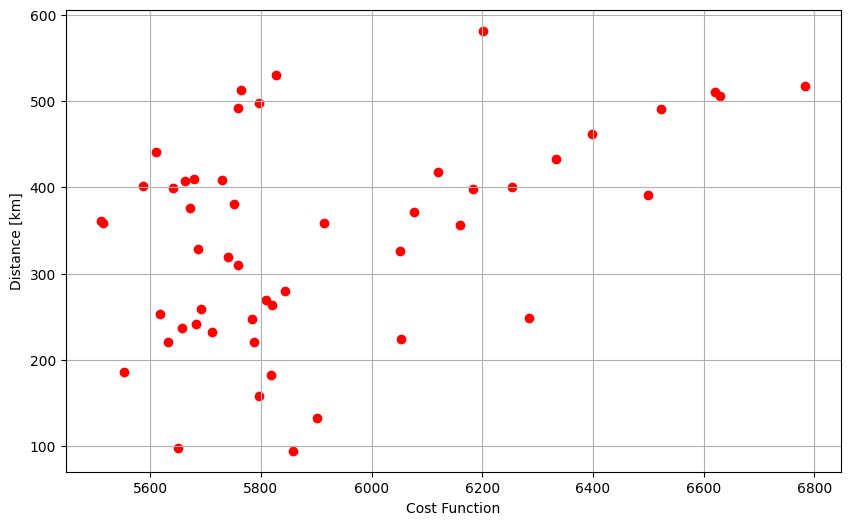

In [ ]:
distance_list = []
center_latitude, center_longitude = find_center(sw_lat, sw_lng, ne_lat, ne_lng)

for point in road_starting_points:
    distance_list.append(geodesic((center_latitude, center_longitude), point).kilometers)

print(len(distance_list))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(cost_function_road_distance, distance_list, color='red', marker='o')

plt.xlabel('Cost Function')
plt.ylabel('Distance [km]')

plt.grid(True)
plt.show()

In [ ]:
mean = np.mean(cost_function_real_distance)
std_dev = np.std(cost_function_real_distance)

print(f"Standard Deviation: {std_dev}")
print(f"Mean Value: {mean}")

mean = np.mean(cost_function_road_distance)
std_dev = np.std(cost_function_road_distance)

print(f"Standard Deviation: {std_dev}")
print(f"Mean Value: {mean}")

Standard Deviation: 256.4552762713463
Mean Value: 4353.509803921569
Standard Deviation: 317.2455644666751
Mean Value: 5909.607843137255
